# Harmonization of MODIS and AVHRR

Following [Rifai et al. (2022)](https://bg.copernicus.org/articles/19/491/2022/)

    <var>-MODIS = s(<var>-AVHRR)+s(month)+s(SZA)+s(TOD)+s(x,y)

This process was run using an R script and the `mgcv` package. This notebook post-processes the output of the GAM harmonization:
- Create plots of before and after harmonization
- Merging the calibrated AVHRR with MODIS to create a continous time-series 1982-2022
- Gapfilling
    
        
    


In [1]:
import numpy as np
import xarray as xr
import seaborn as sb
import pandas as pd
import geopandas as gpd
from scipy import stats
import xskillscore as xs
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_absolute_error
from matplotlib.ticker import FormatStrFormatter

import sys
sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from _collect_prediction_data import round_coords

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize

## Open datasets

In [4]:
var='ndvi'
crs='epsg:4326'

base = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/'

trees_lgbm = xr.open_dataset(base+'NDVI_harmonization/NDVI_trees_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
nontrees_lgbm = xr.open_dataset(base+'NDVI_harmonization/NDVI_nontrees_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']

avhrr = xr.open_dataset(base+'NDVI_harmonization/AVHRR_5km_monthly_1982_2013.nc')['NDVI_avhrr']
avhrr = assign_crs(avhrr, crs=crs)

modis = xr.open_dataset(base+'NDVI_harmonization/MODIS_NDVI_5km_monthly_200003_202212.nc')['NDVI_median']
modis = assign_crs(modis, crs=crs)

### Combine trees and nontrees model predictions

In [5]:
merge = xr.where(np.isnan(trees_lgbm), nontrees_lgbm, trees_lgbm)
merge = merge.rename({'y':'latitude', 'x': 'longitude'})

#ensure we only have data where there is AVHRR data (this is unnecessary but being sure)
avhrr_mask = xr.open_dataarray('/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/AVHRR_filtered_mask_1982_2013.nc')
merge = merge.where(avhrr_mask)

#clip MODIS to same areas
modis = modis.sel(time=slice('2001', '2013')).where(avhrr_mask.sel(time=slice('2001', '2013')))

#modis has very slightly different extent so clip further
modis_mask = ~np.isnan(modis)
merge = merge.sel(time=modis.time).where(modis_mask)
avhrr = avhrr.sel(time=modis.time)
avhrr = avhrr.where(modis_mask)

## Comparisons

### Scatter plots of before and after harmonization

Per bioclimatic region

In [6]:
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')
n_samples=30000

In [9]:
# Dictionary to save results 
results = []
for index, row in gdf.iterrows():

    n=int(n_samples/6)        

    print(row['region_name'], n)
    
    # Generate a polygon mask to keep only data within the polygon
    mask = xr_rasterize(gdf.iloc[[index]], merge, crs=crs)
    mask = round_coords(mask)
    
    # Mask dataset to set pixels outside the polygon to `NaN`
    modis_flat = modis.where(mask).values.flatten()
    avhrr_flat = avhrr.where(mask).values.flatten()
    avhrr_adjust = merge.where(mask).values.flatten()

    df = pd.DataFrame({'MODIS':modis_flat, 'AVHRR-original':avhrr_flat, 'AVHRR-adjusted':avhrr_adjust})
    df = df.dropna().sample(n=n, random_state=0).reset_index(drop=True)
    df['Region'] = row['region_name']
    results.append(df)

df = pd.concat(results).reset_index(drop=True)

Tropics 5000
Savanna 5000
Warm Temperate 5000
Cool Temperate 5000
Mediterranean 5000
Desert 5000


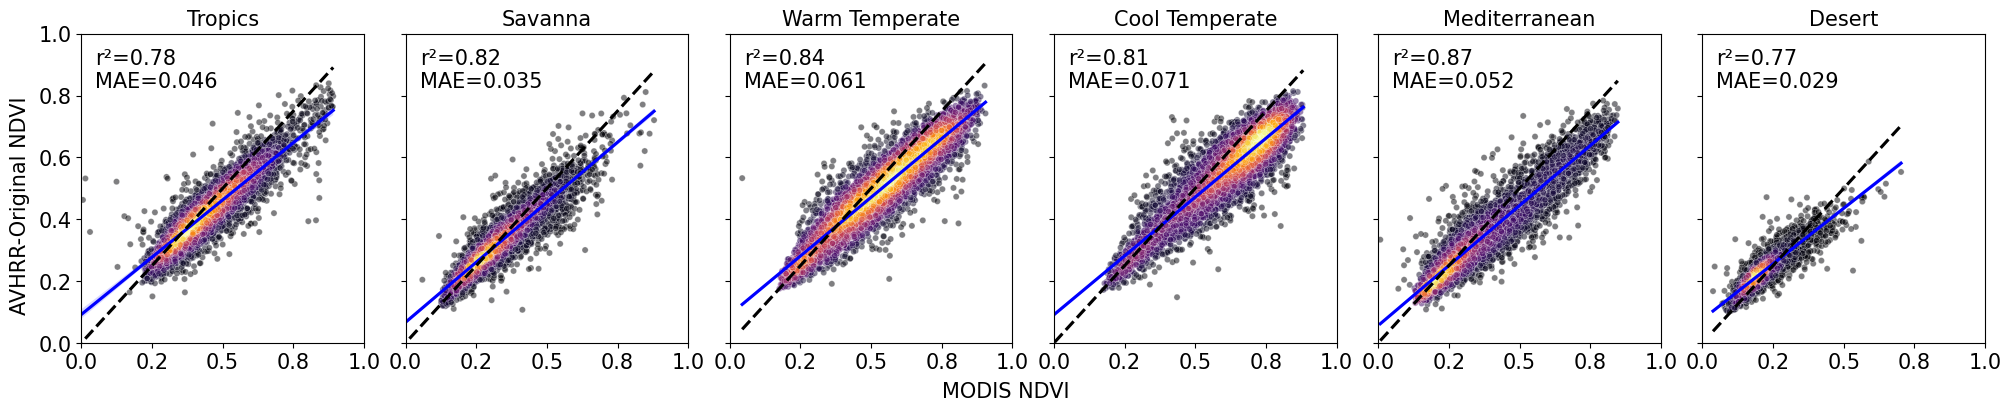

In [10]:
fig,ax = plt.subplots(1,6, figsize=(20,4), sharey=True, layout='constrained')
font=15

for ax, region in zip(ax.ravel(), list(df['Region'].unique())):
    df_region = df[df['Region']==region]
    obs,pred = df_region['MODIS'].values, df_region['AVHRR-original'].values
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    r2 = r_value**2
    ac = mean_absolute_error(obs, pred)
    
    xy = np.vstack([obs,pred])
    z = gaussian_kde(xy)(xy)
    
    sb.scatterplot(data=df_region, x='MODIS',y='AVHRR-original', c=z, s=20, lw=1, alpha=0.5, ax=ax, cmap='inferno')
    sb.regplot(data=df_region, x='MODIS',y='AVHRR-original', scatter=False, color='blue', ax=ax)
    sb.regplot(data=df_region, x='MODIS',y='MODIS', color='black', scatter=False, line_kws={'linestyle':'dashed'}, ax=ax)
    
    ax.set_title(region, fontsize=font)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(0.0,1.0)
    ax.set_xlim(0.0,1.0)
    ax.text(.05, .90, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(np.mean(r2)),
            transform=ax.transAxes, fontsize=font)
    ax.text(.05, .825, 'MAE={:.2g}'.format(np.mean(ac)),
            transform=ax.transAxes, fontsize=font)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    ax.tick_params(axis='x', labelsize=font)
    ax.tick_params(axis='y', labelsize=font)

fig.supylabel('AVHRR-Original '+var.upper(), fontsize=font)
fig.supxlabel('MODIS '+var.upper(), fontsize=font);
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/MODIS_AVHRR_"+var+"_onetoone_before_harmonization.png", bbox_inches='tight', dpi=300);

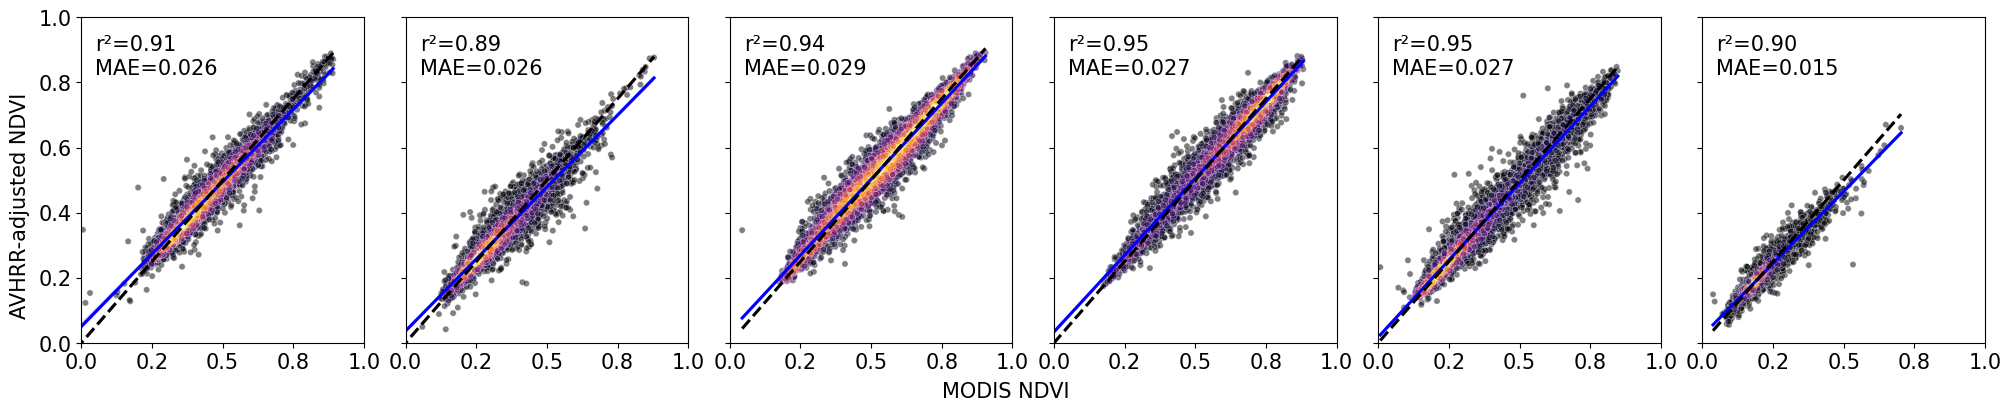

In [11]:
fig,ax = plt.subplots(1,6, figsize=(20,4), sharey=True, layout='constrained')
font=15

for ax, region in zip(ax.ravel(), list(df['Region'].unique())):
    df_region = df[df['Region']==region]
    obs,pred = df_region['MODIS'].values, df_region['AVHRR-adjusted'].values
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    r2 = r_value**2
    ac = mean_absolute_error(obs, pred)
    
    xy = np.vstack([obs,pred])
    z = gaussian_kde(xy)(xy)
    
    sb.scatterplot(data=df_region, x='MODIS',y='AVHRR-adjusted', c=z, s=20, lw=1, alpha=0.5, ax=ax, cmap='inferno')
    sb.regplot(data=df_region, x='MODIS',y='AVHRR-adjusted', scatter=False, color='blue', ax=ax)
    sb.regplot(data=df_region, x='MODIS',y='MODIS', color='black', scatter=False, line_kws={'linestyle':'dashed'}, ax=ax)
    
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(0.0,1.0)
    ax.set_xlim(0.0,1.0)
    ax.text(.05, .90, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(np.mean(r2)),
            transform=ax.transAxes, fontsize=font)
    ax.text(.05, .825, 'MAE={:.2g}'.format(np.mean(ac)),
            transform=ax.transAxes, fontsize=font)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    ax.tick_params(axis='x', labelsize=font)
    ax.tick_params(axis='y', labelsize=font)

fig.supylabel('AVHRR-adjusted '+var.upper(), fontsize=font)
fig.supxlabel('MODIS '+var.upper(), fontsize=font);
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/MODIS_AVHRR_"+var+"_onetoone_after_harmonization.png", bbox_inches='tight', dpi=300);

### Timeseries plots

Tropics
Savanna
Warm Temperate
Cool Temperate
Mediterranean
Desert


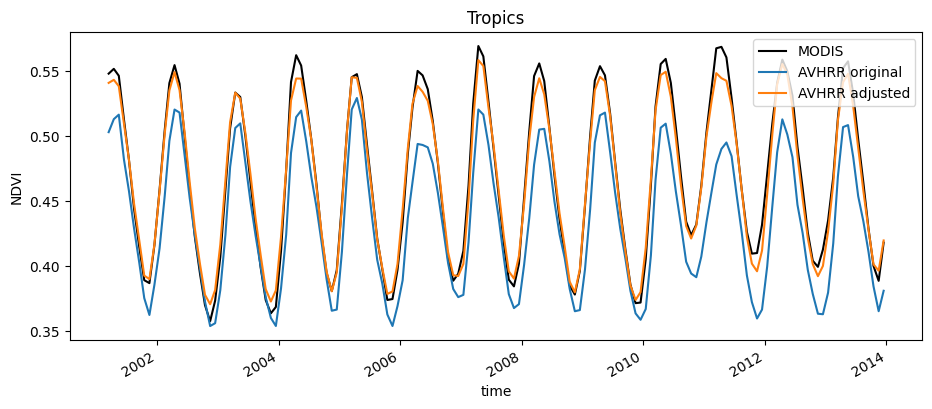

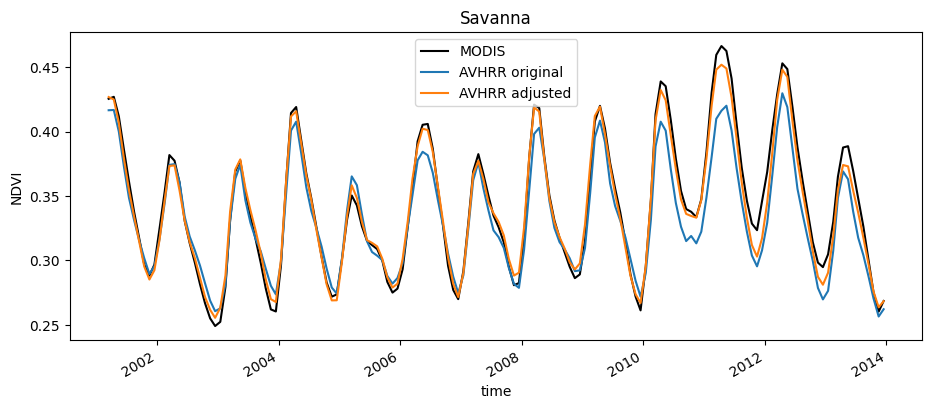

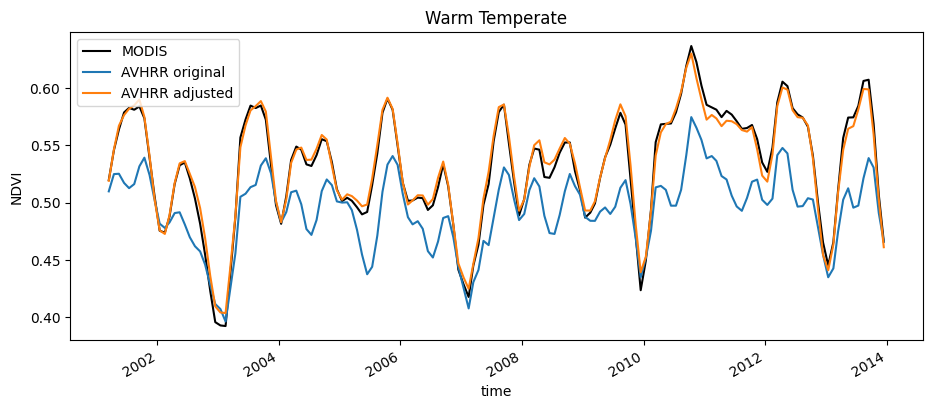

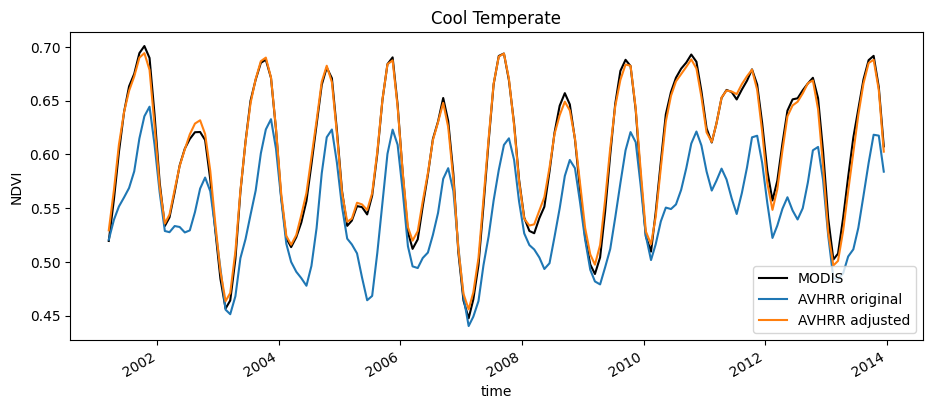

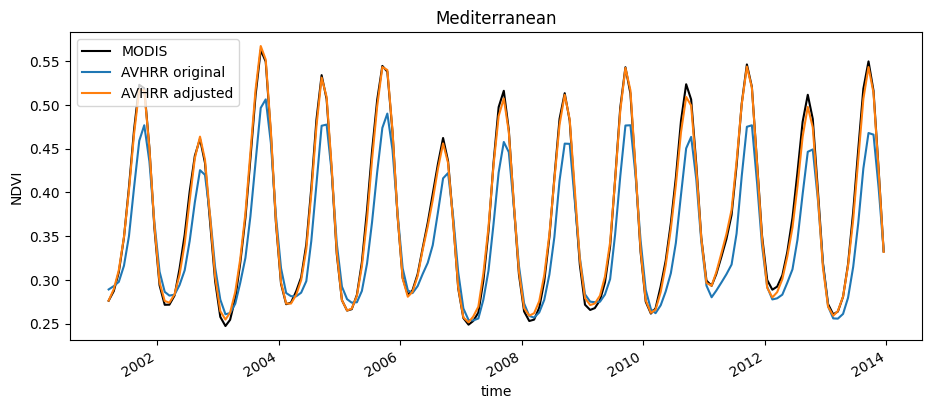

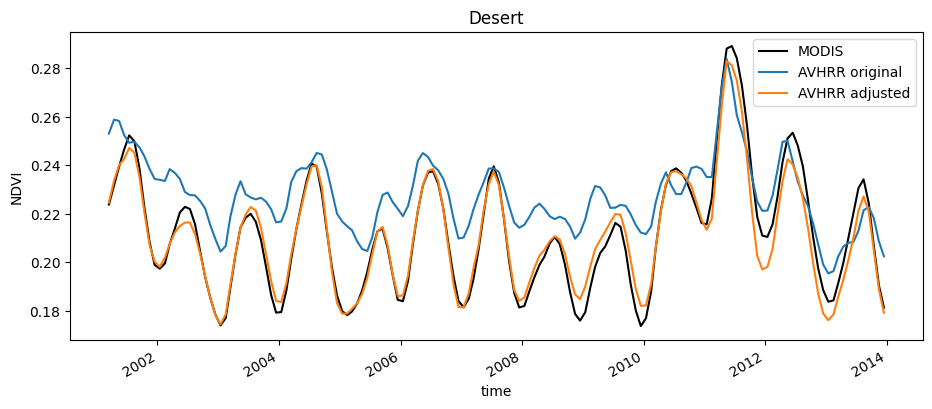

In [14]:
for index, row in gdf.iterrows():
    print(row['region_name'])
        
    # Generate a polygon mask to keep only data within the polygon
    mask = xr_rasterize(gdf.iloc[[index]], merge, crs=crs)
    mask = round_coords(mask)
    
    # Mask dataset to set pixels outside the polygon to `NaN`
    modis_region = modis.where(mask)
    avhrr_region = avhrr.where(mask)
    merge_region = merge.where(mask)
    
    fig, ax = plt.subplots(1,1, figsize=(11,4))
    modis_region.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=ax, label='MODIS', c='black')
    avhrr_region.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=ax, label='AVHRR original')
    merge_region.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=ax, label='AVHRR adjusted')
    ax.legend()
    ax.set_title(row['region_name']);

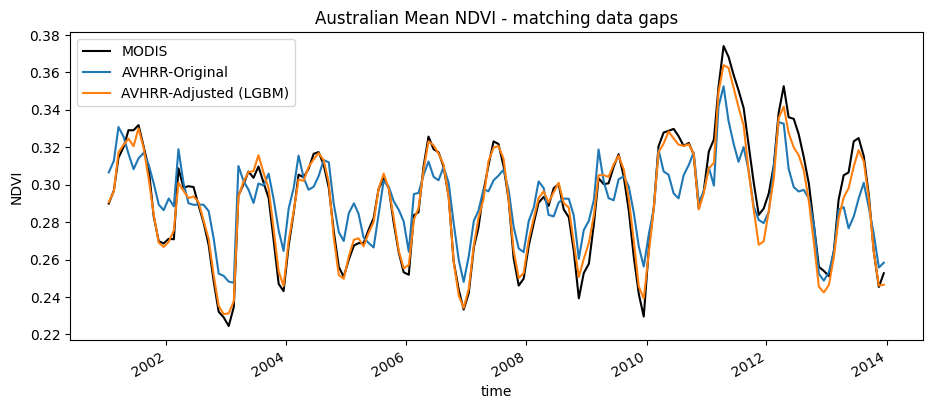

In [15]:
fig,ax = plt.subplots(1,1, figsize=(11,4))
modis.mean(['latitude','longitude']).plot(ax=ax, label='MODIS', color='black')
avhrr.mean(['latitude','longitude']).plot(ax=ax, label='AVHRR-Original')
merge.mean(['latitude','longitude']).plot(ax=ax, label='AVHRR-Adjusted (GBM)')
ax.set_title('Australian Mean NDVI - matching data gaps')
ax.set_ylabel('NDVI')
ax.legend();

### Per-pixel error metrics

In [16]:
modis_mean = modis.mean('time')
low_ndvi_mask = xr.where(modis_mean<0.1,0, 1)

In [17]:
adjusted_corr = xr.corr(modis,merge,dim='time')
adjusted_corr = adjusted_corr.where(low_ndvi_mask)
orig_corr = xr.corr(modis, avhrr.sel(time=slice('2001', '2013')), dim='time')
orig_corr = orig_corr.where(low_ndvi_mask)

adjusted_rmse = xs.rmse(modis,merge,dim='time', skipna=True)
adjusted_rmse = adjusted_rmse.where(low_ndvi_mask)
orig_rmse = xs.rmse(modis,avhrr.sel(time=slice('2001', '2013')), dim='time', skipna=True)
orig_rmse = orig_rmse.where(low_ndvi_mask)

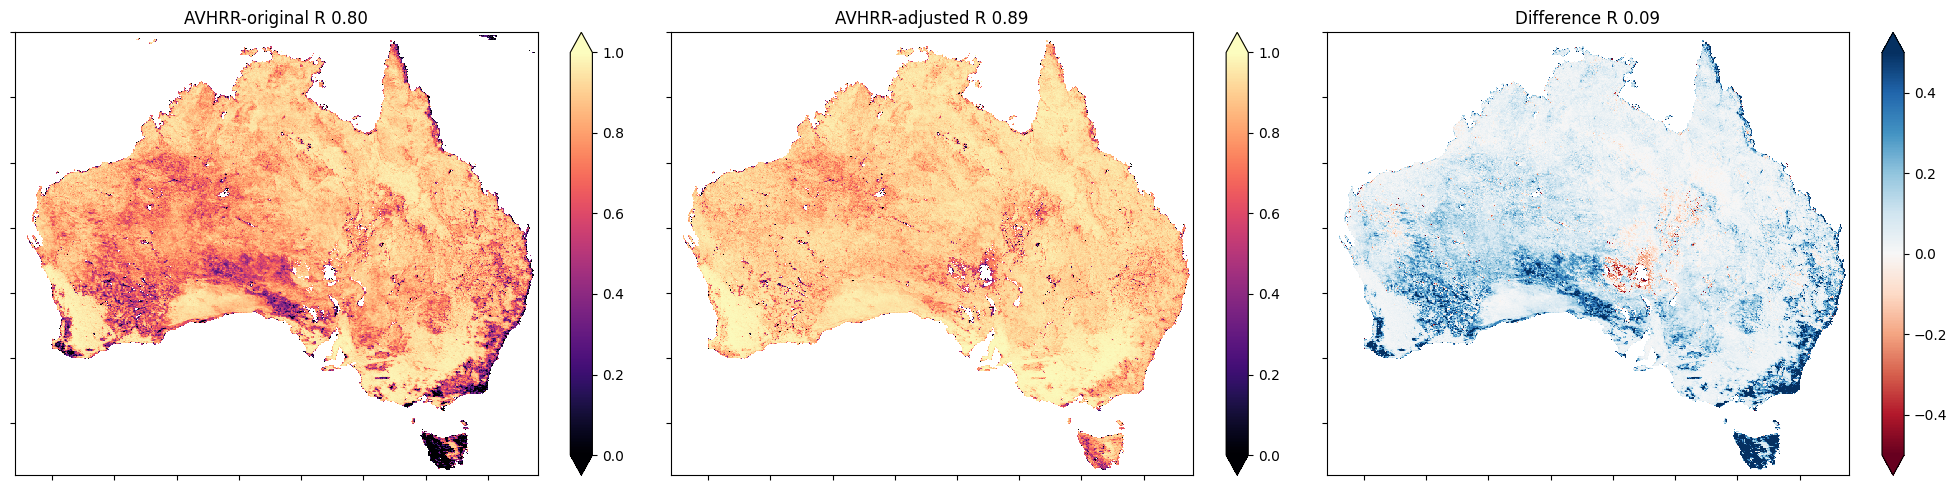

In [18]:
corr_data = [orig_corr, adjusted_corr, adjusted_corr-orig_corr]
products=['AVHRR-original', 'AVHRR-adjusted', 'Difference']

fig,axes = plt.subplots(1,3, figsize=(20,5), sharey=True)

for ax, ds, n in zip(axes.ravel(), corr_data, products):
    if n=='Difference':
        cmap='RdBu'
        vmin=-0.5
        vmax=0.5
    else:
        cmap='magma'
        vmin=0
        vmax=1
    im = ds.plot.imshow(vmin=vmin, vmax=vmax, cmap=cmap, ax=ax, add_colorbar=True)
    ax.set_title(f'{n} R '"{:.2f}".format(ds.mean().values))
    #ax.set_title(n,  fontsize=15);
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticklabels([])

# fig.subplots_adjust(wspace=0.05)
# fig.colorbar(im, ax=axes.ravel().tolist(), pad=0.01, label='Correlation');
# plt.suptitle('Correlation', fontsize=15)
plt.tight_layout();

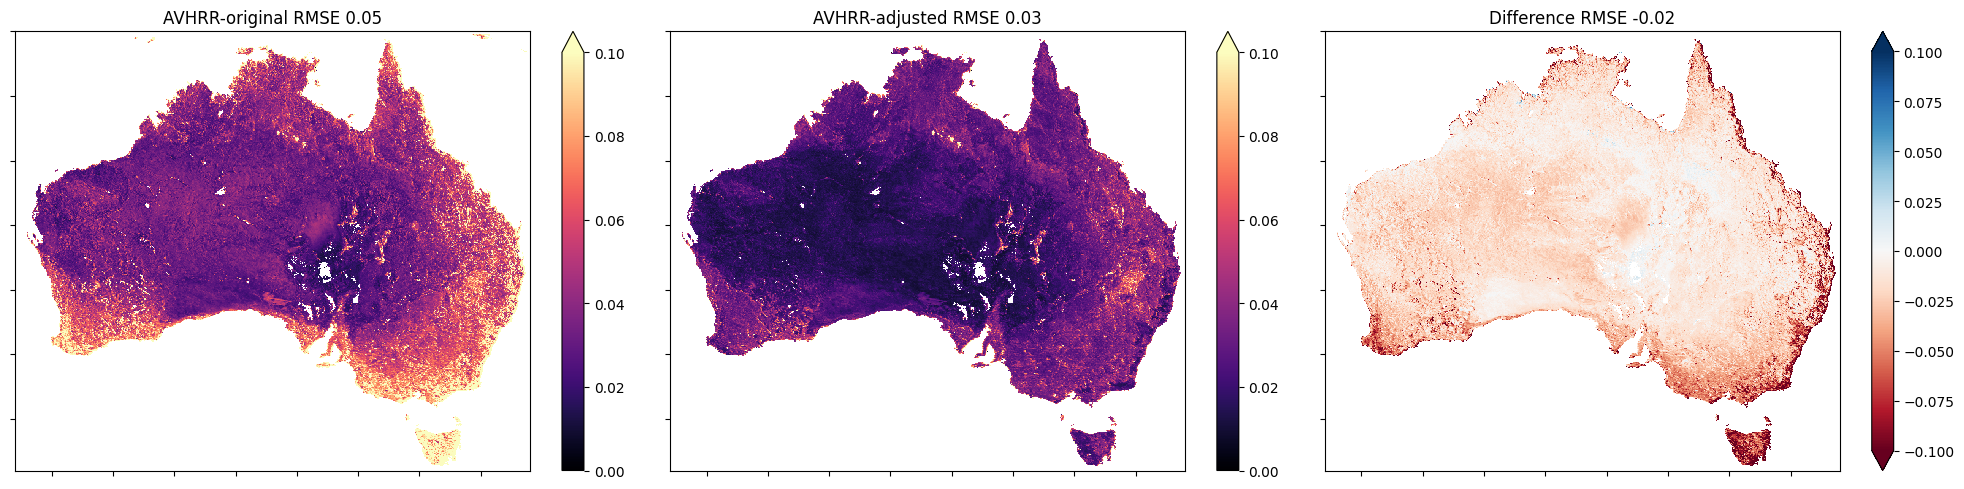

In [20]:
corr_data = [orig_rmse, adjusted_rmse, adjusted_rmse-orig_rmse]
products=['AVHRR-original', 'AVHRR-adjusted', 'Difference']

fig,axes = plt.subplots(1,3, figsize=(20,5), sharey=True)

for ax, ds, n in zip(axes.ravel(), corr_data, products):
    if n=='Difference':
        cmap='RdBu'
        vmin=-0.1
        vmax=0.1
    else:
        cmap='magma'
        vmin=0.0
        vmax=0.1
    im = ds.plot.imshow(vmin=vmin, vmax=vmax, cmap=cmap, ax=ax, add_colorbar=True)
    ax.set_title(f'{n} RMSE '"{:.2f}".format(ds.mean().values))
    #ax.set_title(n,  fontsize=15);
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticklabels([])

# fig.subplots_adjust(wspace=0.05)
# fig.colorbar(im, ax=axes.ravel().tolist(), pad=0.01, label='Correlation');
# plt.suptitle('Correlation', fontsize=15)
plt.tight_layout();

## Merge calibrated AVHRR with MODIS

reopen datasets and merge

In [21]:
base = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/'

trees_lgbm = xr.open_dataset(base+'NDVI_harmonization/NDVI_trees_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
nontrees_lgbm = xr.open_dataset(base+'NDVI_harmonization/NDVI_nontrees_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']

modis = xr.open_dataset(base+'NDVI_harmonization/MODIS_NDVI_5km_monthly_200003_202212.nc')['NDVI_median']
modis = assign_crs(modis, crs=crs)

merge = xr.where(np.isnan(trees_lgbm), nontrees_lgbm, trees_lgbm)
merge = merge.rename({'y':'latitude', 'x': 'longitude'})
merge = assign_crs(merge, crs=crs)


In [26]:
merged = xr.concat([merge.sel(time=slice('1982','2000-02')),
                    modis.rename(var.upper())],
                   dim='time')
merged = merged.rename(var.upper())

(0.2, 0.4)

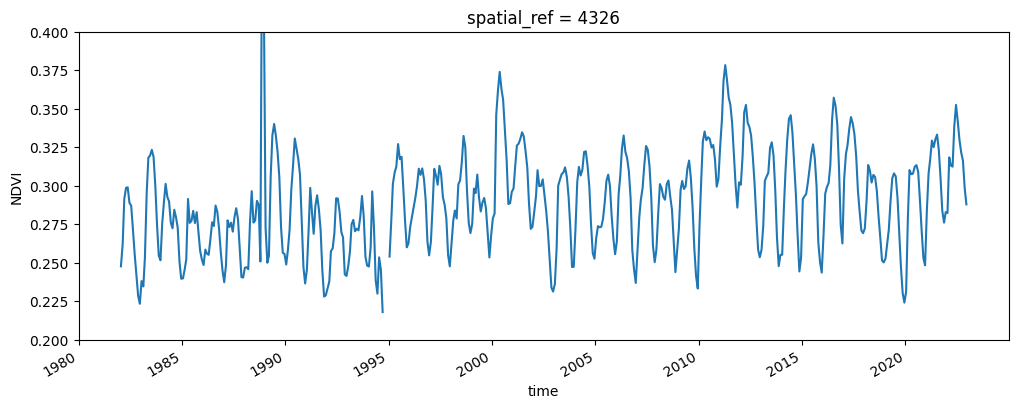

In [30]:
merged.mean(['latitude', 'longitude']).plot(figsize=(12,4))
plt.ylim(0.2,0.4)

In [28]:
merged.astype(np.float32).to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/'+var.upper()+'_harmonization/'+var.upper()+'_LGBM_5km_monthly_1982_2022_wGaps.nc')

In [ ]:
# if var=='ndvi':
#     gbox = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/WCF_5km_monthly_1990_2022.nc').odc.geobox

# #grab some time-slices from another dataset
# missing_time_steps = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/WCF_5km_monthly_1990_2022.nc').sel(time=slice('1994-10', '1994-12')).time

### Open the calibrated AVHRR

extract timeseries 1982-2000, resample to epsg:4326 (only if NDVI)

In [ ]:
# ds = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/'+var.upper()+'_harmonization/Harmonized_'+var.upper()+'_AVHRR_MODIS_1982_2013.nc'),
#                    crs=crs)

# ds_pred = ds[var+'_mcd_pred']
# ds_pred = ds_pred.rename(var.upper()).sel(time=slice('1982', '2000'))
# ds_pred.attrs['nodata'] = np.nan

# if var=='ndvi':
#     ds_pred = ds_pred.odc.reproject(gbox, resampling='bilinear')
# ds_pred = round_coords(ds_pred)

### Creating three empty slices of data

and merge back with calibrated avhrr

In [ ]:
# extras = ds_pred.isel(time=range(0,3)) # just grab 3 random slices
# extras = xr.where(extras>100000,np.nan, np.nan) #make values all NaNs
# extras['time'] = missing_time_steps #change time-stamp to missing values
# extras = round_coords(extras)

In [ ]:
# ds_pred = xr.concat([ds_pred, extras], dim='time').sortby('time')